File used for testing the functions in the repository

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
# import predict_polynomial_signal from Predicted_signal.py
from source.Losses import MSE, compute_parameter_loss
from source.Predicted_signal import predict_polynomial
from data.Polynomial_test import generate_polynomial_data
from data.Polynomial_test import load_polynomial_data

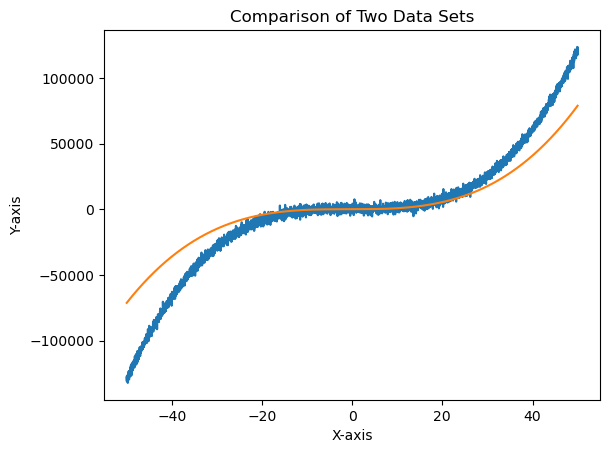

MSE: 377951554.70960057


In [3]:
# Coefficients for the polynomial (a0, a1, a2, a3, a4)
true_coefficients = [250, 2.5, -2, 1]
list = np.linspace(-50, 50, 5000)
estimated_coefficients = [0, 1.2, 1.5, 0.6]

result = generate_polynomial_data(true_coefficients, list, noise_level=2000)
prediction = predict_polynomial(estimated_coefficients, list)

plt.plot(list, result)
plt.plot(list, prediction)

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Comparison of Two Data Sets')

plt.show()

print("MSE:", MSE(result, prediction))

In [4]:
# Get two tensors

a = np.array([1, 2, 3, 4, -7])
b = np.array([1, 2, 3, 4, 5])

inputs_tensor = torch.tensor(a, dtype=torch.float32)
true_params_tensor = torch.tensor(b, dtype=torch.float32)


print("Parameter Loss:", compute_parameter_loss(inputs_tensor, true_params_tensor))

Parameter Loss: tensor(-2.4000)


In [5]:
print(np.random.randn(4))

[-0.98043052  0.85893807 -0.29445184  0.5794263 ]
